In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras.initializers import glorot_uniform
from keras import backend as K
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from mtcnn.mtcnn import MTCNN #https://github.com/ipazc/mtcnn

from scipy import spatial
#from utils import *
from utils import LRN2D
import utils
#from inception_blocks_v2 import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [2]:
def image_to_embedding(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [3]:
myInput = Input(shape=(96, 96, 3))

x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(LRN2D, name='lrn_1')(x)
x = Conv2D(64, (1, 1), name='conv2')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(192, (3, 3), name='conv3')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
x = Activation('relu')(x)
x = Lambda(LRN2D, name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Inception3a
inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

# Inception3b
inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

# Inception3c
inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_3x3',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))

inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))

inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

#inception 4a
inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=192,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(1, 1),
                                   padding=(2, 2))

inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)
inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                   layer='inception_4a_pool',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   padding=(2, 2))
inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

#inception4e
inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_3x3',
                                   cv1_out=160,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))
inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_5x5',
                                   cv1_out=64,
                                   cv1_filter=(1, 1),
                                   cv2_out=128,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))
inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

#inception5a
inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))

inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)
inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                   layer='inception_5a_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   padding=(1, 1))
inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

#inception_5b
inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                   layer='inception_5b_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1))
inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)


# Final Model
model = Model(inputs=[myInput], outputs=norm_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Load weights from csv files (which was exported from Openface torch model)
weights = utils.weights
weights_dict = utils.load_weights()

# Set layer weights of the model
for name in weights:
    if model.get_layer(name) != None:
        model.get_layer(name).set_weights(weights_dict[name])
    elif model.get_layer(name) != None:
        model.get_layer(name).set_weights(weights_dict[name])

In [5]:
##check if model is loaded properly
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Matching Face

In [6]:
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


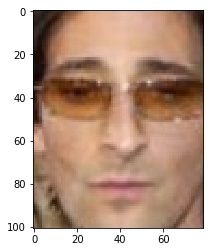

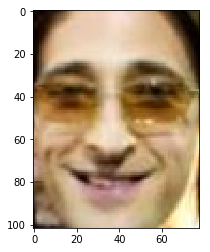

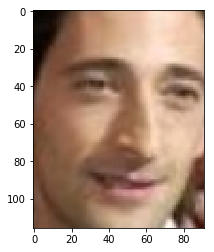

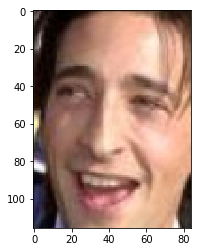

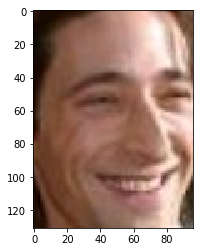

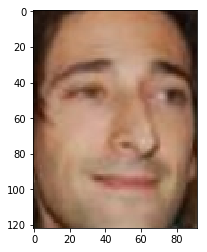

In [7]:
import glob

detector = MTCNN()

result = []
images_cropped = []
test_encoding = []
test_images = [cv2.imread(file) for file in glob.glob("images/faces/Adrien_Brody/test/*.jpg")]
for i in range(len( test_images)): 
    plt.figure()
    result.append(detector.detect_faces(test_images[i]))
    #print(result[i])
    temp = result[i].copy()
    temp1 = test_images[i].copy()
    (x, y, w, h) = temp[0]['box']
    #draw rectangle in first face detected
    #for i in range(1):
    #   cv2.rectangle(images1[i], (x, y), (x+w, y+h), (0, 255, 0), 2)
    #images_cropped.append(temp1[x:h,y:w])
    images_cropped.append(temp1[y:y+h,x:x+w].copy())
    test_encoding.append( image_to_embedding(images_cropped[i], model ) )
    plt.imshow(convertToRGB(images_cropped[i]))

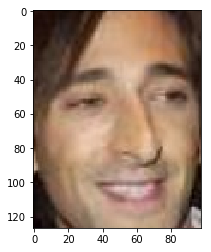

In [8]:
#stores face record
face_embedding_dictionary =  {}

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_image = cv2.imread('images/faces/Adrien_Brody/train/Adrien_Brody_0001.jpg')  # this is a PIL image

plt.figure()
faces = detector.detect_faces(train_image)
temp = faces.copy()
temp1 = train_image.copy()
(x, y, w, h) = temp[0]['box']
train_image_cropped = temp1[y:y+h,x:x+w].copy()
plt.imshow(convertToRGB(train_image_cropped))
#x = img_to_array(train_image_cropped)  # this is a Numpy array with shape (3, 150, 150)
x = train_image_cropped.reshape((1,) + train_image_cropped.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

train_encoding = image_to_embedding(train_image_cropped, model )

face_embedding_dictionary["Adrien Brody"] = train_encoding

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,save_to_dir='images/faces/Adrien_Brody/generated', save_prefix='Adrien_Brody', save_format='jpeg'):
    i += 1
    if i > 5:
        break 

In [9]:
#returns euclidean distance
def euclideanDistance(emb,test_encodings):
    distance = np.linalg.norm(emb - test_encodings)
    return distance

In [10]:
image_distance = []
for i in range(len(test_encoding)):
    image_distance.append(euclideanDistance( train_encoding ,test_encoding[i] ))
    print(image_distance[i])
    if(image_distance[i] < 0.9):
        print("Similar in: " + str(i))
    #else: print(not_matched(test_encoding[i])) 

0.65209913
Similar in: 0
0.6561125
Similar in: 1
0.7842744
Similar in: 2
0.55729276
Similar in: 3
0.7780998
Similar in: 4
0.67113537
Similar in: 5


### Dissimilar Face

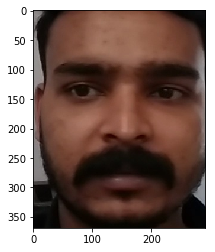

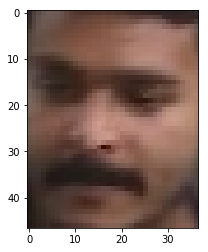

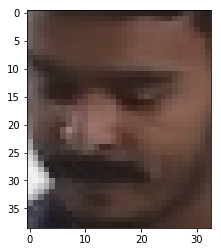

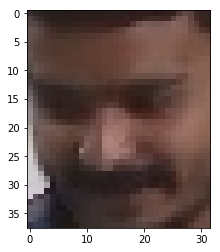

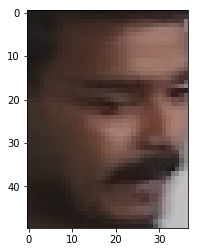

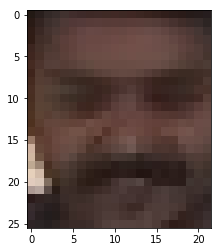

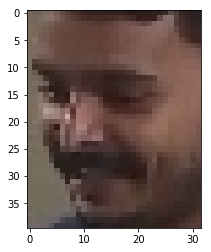

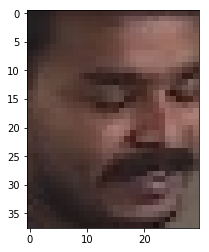

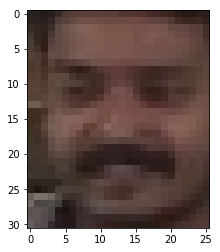

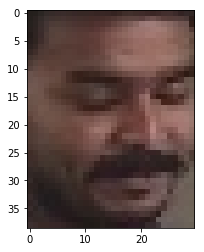

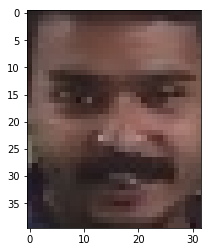

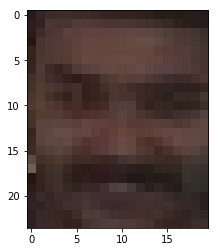

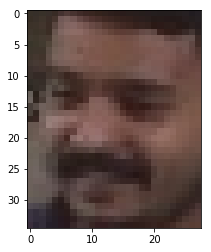

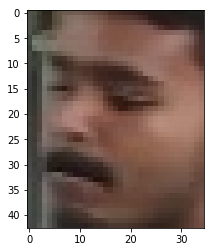

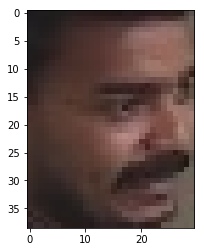

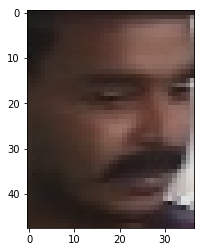

In [11]:

result = []
images_cropped = []
test_encoding = []
test_images = [cv2.imread(file) for file in glob.glob("*.jpg")]
for i in range(len( test_images)): 
    plt.figure()
    result.append(detector.detect_faces(test_images[i]))
    #print(result[i])
    temp = result[i].copy()
    temp1 = test_images[i].copy()
    (x, y, w, h) = temp[0]['box']
    #draw rectangle in first face detected
    #for i in range(1):
    #   cv2.rectangle(images1[i], (x, y), (x+w, y+h), (0, 255, 0), 2)
    #images_cropped.append(temp1[x:h,y:w])
    images_cropped.append(temp1[y:y+h,x:x+w].copy())
    test_encoding.append( image_to_embedding(images_cropped[i], model ) )
    plt.imshow(convertToRGB(images_cropped[i]))

In [12]:
image_distance = []
for i in range(len(test_encoding)):
    image_distance.append(euclideanDistance( train_encoding ,test_encoding[i] ))
    #print(image_distance[i])
    if(image_distance[i] < 0.9):
        print("Matched with: "+ str(i) + "th")

Matched with: 4th


only one of the dissimilar faces are matching

#### Face 2 

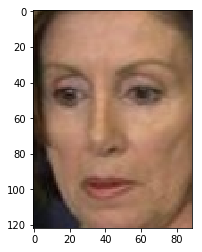

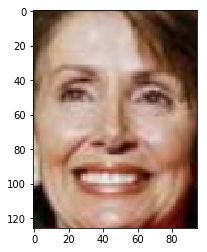

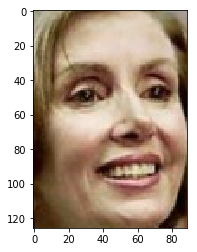

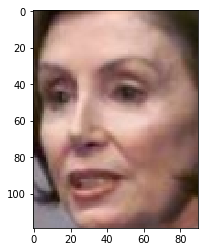

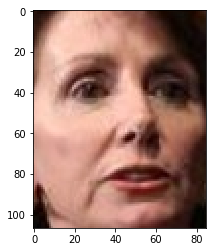

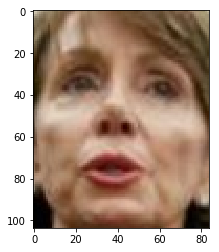

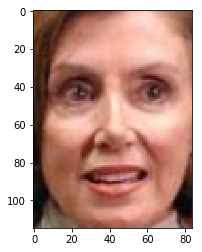

In [13]:
import glob

detector = MTCNN()

result = []
images_cropped = []
test_encoding = []
test_images = [cv2.imread(file) for file in glob.glob("images/faces/Nancy_Pelosi/test/*.jpg")]
for i in range(len( test_images)): 
    plt.figure()
    result.append(detector.detect_faces(test_images[i]))
    #print(result[i])
    temp = result[i].copy()
    temp1 = test_images[i].copy()
    (x, y, w, h) = temp[0]['box']
    #draw rectangle in first face detected
    #for i in range(1):
    #   cv2.rectangle(images1[i], (x, y), (x+w, y+h), (0, 255, 0), 2)
    #images_cropped.append(temp1[x:h,y:w])
    images_cropped.append(temp1[y:y+h,x:x+w].copy())
    test_encoding.append( image_to_embedding(images_cropped[i], model ) )
    plt.imshow(convertToRGB(images_cropped[i]))

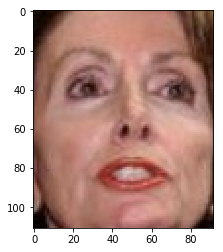

In [14]:
#stores face record
#face_embedding_dictionary =  {}

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_image = cv2.imread('images/faces/Nancy_Pelosi/train/Nancy_Pelosi_0002.jpg')  # this is a PIL image

plt.figure()
faces = detector.detect_faces(train_image)
temp = faces.copy()
temp1 = train_image.copy()
(x, y, w, h) = temp[0]['box']
train_image_cropped = temp1[y:y+h,x:x+w].copy()
plt.imshow(convertToRGB(train_image_cropped))
#x = img_to_array(train_image_cropped)  # this is a Numpy array with shape (3, 150, 150)
x = train_image_cropped.reshape((1,) + train_image_cropped.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

train_encoding = image_to_embedding(train_image_cropped, model )

face_embedding_dictionary["Adrien Brody"] = train_encoding

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,save_to_dir='images/faces/Nancy_Pelosi/generated', save_prefix='Nancy_Pelosi', save_format='jpeg'):
    i += 1
    if i > 5:
        break 

In [15]:
image_distance = []
for i in range(len(test_encoding)):
    image_distance.append(euclideanDistance( train_encoding ,test_encoding[i] ))
    print(image_distance[i])
    if(image_distance[i] < 0.9):
        print("Similar in: " + str(i))
    #else: print(not_matched(test_encoding[i])) 
print(len(test_encoding))

0.6859832
Similar in: 0
0.6595127
Similar in: 1
0.74384975
Similar in: 2
0.7544552
Similar in: 3
0.7296019
Similar in: 4
0.7477637
Similar in: 5
0.7293402
Similar in: 6
7


#### What if some similar faces aren't matching?

We can apply further preprocessing beyond just cropping face. For Example
1. Histogram Equalization
2. Resizing all images to same dimension
3. Non-local Means Denoising algorithm

In [16]:
def image_to_embedding_processed(image, model):
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

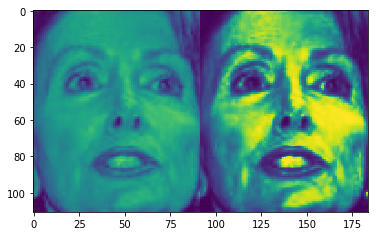

In [46]:
gray_img = cv2.cvtColor(convertToRGB(train_image_cropped), cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(gray_img)
res = np.hstack((gray_img,equ)) #stacking images side-by-side
equ = np.repeat(equ[:, :, np.newaxis], 3, axis=2)
image_hist = equ.copy()
#print(train_image_cropped.shape)
#print(equ.shape)
emb1 = image_to_embedding_processed(equ,model)
plt.imshow(res)
#print(emb)
#plt.imshow()

7


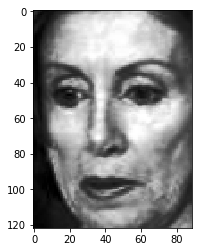

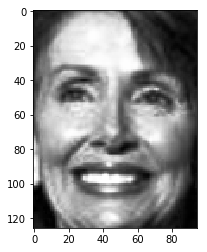

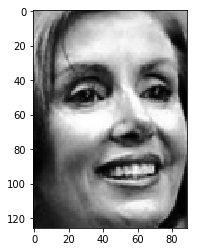

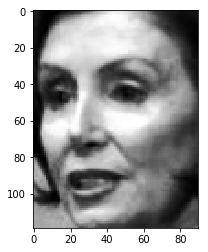

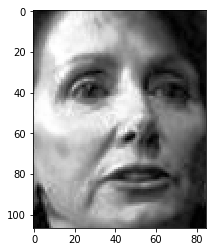

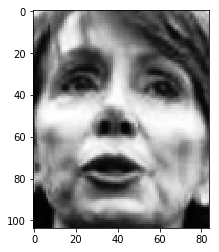

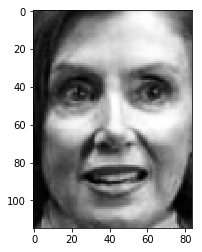

In [41]:
#preprocessing test images
test_encoding1 = []
for i in range(len(images_cropped)): 
    plt.figure()
    gray_img = cv2.cvtColor(convertToRGB(images_cropped[i]) , cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray_img)
    res = np.hstack((gray_img,equ)) #stacking images side-by-side
    equ = np.repeat(equ[:, :, np.newaxis], 3, axis=2)
    test_encoding1.append(image_to_embedding_processed(equ,model))
    plt.imshow(equ)
print(len(test_encoding1))

In [43]:
image_distance1 = []
print(len(test_encoding))
for i in range(len(test_encoding)):
    
    image_distance1.append(euclideanDistance( train_encoding ,test_encoding1[i] ))
    print(image_distance1[i])
    if(image_distance1[i] < 0.9):
        print("Similar in: " + str(i))
    #else: print(not_matched(test_encoding[i])) 

7
0.6784362
Similar in: 0
0.818996
Similar in: 1
0.80740875
Similar in: 2
0.7946883
Similar in: 3
0.7643654
Similar in: 4
0.69687253
Similar in: 5
0.92756784


For most of the cases the distance has decreased.

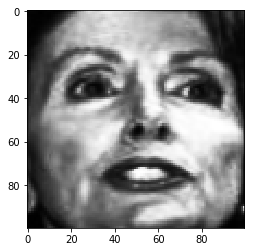

In [47]:
img = cv2.resize(image_hist,(100,100))
#res = np.hstack((gray_img,img))
#equ = np.repeat(equ[:, :, np.newaxis], 3, axis=2)
#print(train_image_cropped.shape)
#print(equ.shape)
emb1 = image_to_embedding_processed(img,model)
plt.imshow(img)

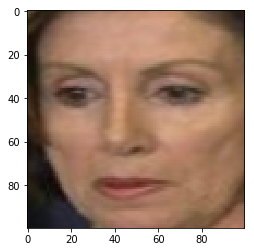

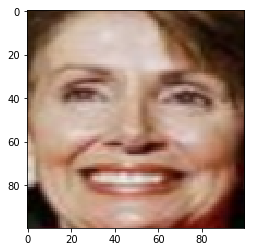

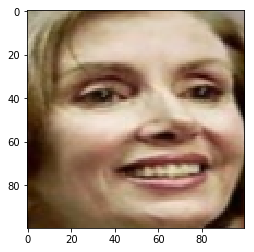

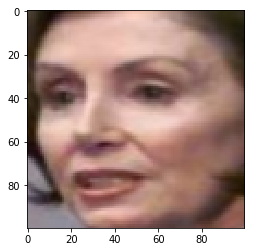

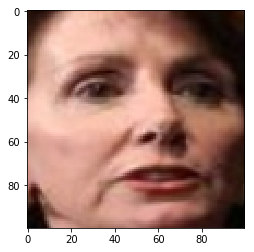

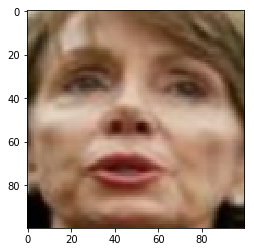

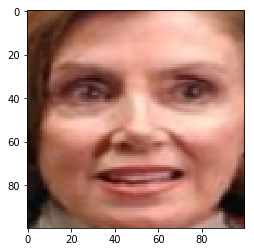

In [48]:
#preprocessing test images
test_encodings2 = []
for i in range(len(images_cropped)): 
    plt.figure()
    img = cv2.resize(images_cropped[i],(100,100))
    test_encodings2.append(image_to_embedding_processed(img,model))
    plt.imshow(convertToRGB(img))
#print(len(test_encoding))
#print(len(images_cropped))

In [49]:
image_distance = []
for i in range(len(test_encoding)):
    image_distance.append(euclideanDistance(train_encoding ,test_encodings2[i] ))
    print(image_distance[i])
    if(image_distance[i] < 0.9):
        print("Similar in: " + str(i))
    #else: print(not_matched(test_encoding[i])) 

0.68171287
Similar in: 0
0.683698
Similar in: 1
0.74606
Similar in: 2
0.7453173
Similar in: 3
0.74266183
Similar in: 4
0.74448645
Similar in: 5
0.73924685
Similar in: 6


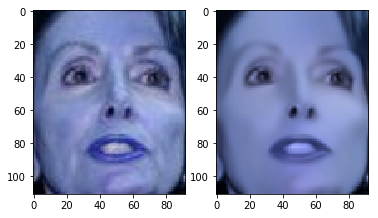

In [66]:
#Non-local Means Denoising algorithm
filtered1 = cv2.fastNlMeansDenoisingColored(train_image_cropped,None,10,10,7,21)
emb2 = image_to_embedding_processed(filtered1,model)
plt.subplot(121),plt.imshow(train_image_cropped)
plt.subplot(122),plt.imshow(filtered1)
plt.show()

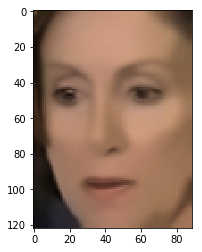

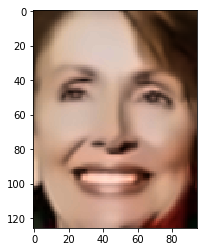

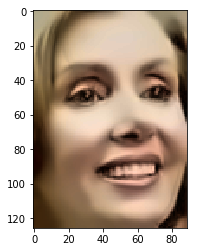

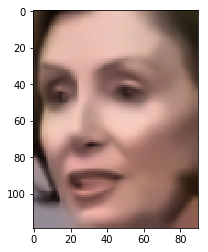

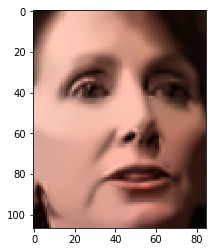

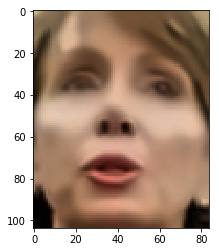

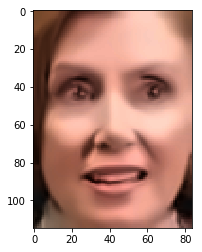

In [74]:
#preprocessing test images
test_encoding1 = []
for i in range(len(images_cropped)): 
    plt.figure()
    filtered = cv2.fastNlMeansDenoisingColored(convertToRGB(images_cropped[i]),None,10,10,7,21)
    #emb = image_to_embedding_processed(filtered,model)
    #res = np.hstack((filtered,equ)) #stacking images side-by-side
    #print(filtered.shape)
    #equ = np.repeat(filtered[:, :, np.newaxis], 3, axis=2)
    test_encoding1.append(image_to_embedding_processed(filtered,model))
    plt.imshow(filtered)
#print(len(test_encoding1))

In [75]:
image_distance = []
for i in range(len(test_encoding)):
    image_distance.append(euclideanDistance( emb2,test_encoding1[i] ))
    print(image_distance[i])
    if(image_distance[i] < 0.9):
        print("Similar in: " + str(i))
    #else: print(not_matched(test_encoding[i])) 
print(len(test_encoding))

0.6129824
Similar in: 0
0.75012
Similar in: 1
0.7628208
Similar in: 2
0.72693384
Similar in: 3
0.8120564
Similar in: 4
0.6513356
Similar in: 5
0.7451659
Similar in: 6
7


### Dissimilar Face

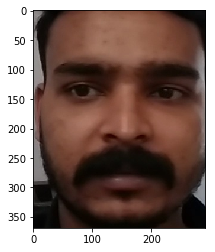

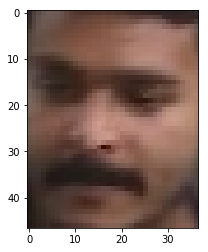

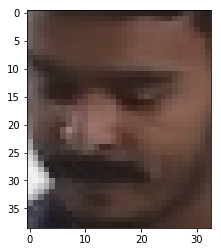

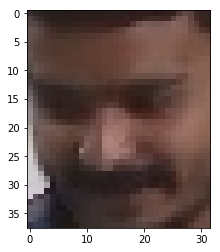

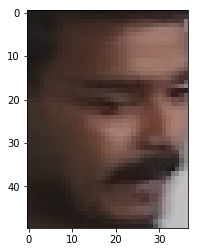

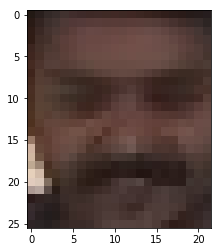

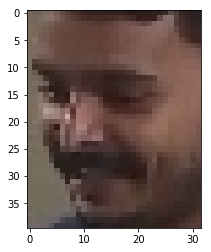

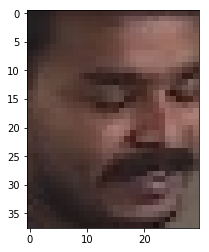

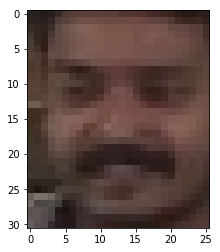

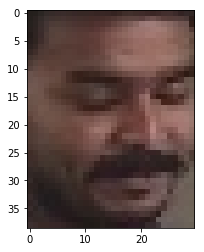

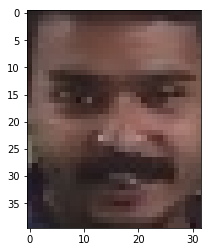

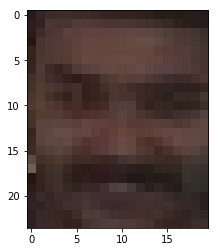

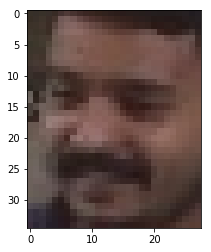

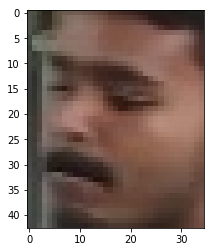

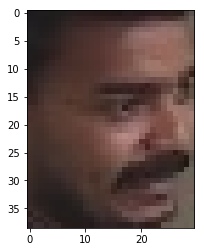

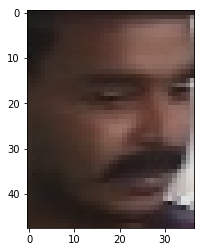

In [76]:

result = []
images_cropped1 = []
test_encoding = []
test_images = [cv2.imread(file) for file in glob.glob("*.jpg")]
for i in range(len( test_images)): 
    plt.figure()
    result.append(detector.detect_faces(test_images[i]))
    #print(result[i])
    temp = result[i].copy()
    temp1 = test_images[i].copy()
    (x, y, w, h) = temp[0]['box']
    #draw rectangle in first face detected
    #for i in range(1):
    #   cv2.rectangle(images1[i], (x, y), (x+w, y+h), (0, 255, 0), 2)
    #images_cropped.append(temp1[x:h,y:w])
    images_cropped1.append(temp1[y:y+h,x:x+w].copy())
    test_encoding.append( image_to_embedding(images_cropped1[i], model ) )
    plt.imshow(convertToRGB(images_cropped1[i]))

In [77]:
image_distance = []
for i in range(len(test_encoding)):
    image_distance.append(euclideanDistance( train_encoding ,test_encoding[i] ))
    print(image_distance[i])
    if(image_distance[i] < 0.9):
        print("Matched with: "+ str(i) + "th")

1.3362415
1.2363545
1.2835048
1.1771225
0.89799255
Matched with: 4th
1.2186879
1.2668954
1.1912669
1.3377635
1.2684598
1.1902772
1.1173302
1.260725
1.3820919
0.97308683
1.2137843


Only of the dissimilar faces are matching